<a href="https://colab.research.google.com/github/songqsh/18ma573v01/blob/master/src/20bsm_calibration_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Volatility calibration to BSM

## Abstract

- Goal
    - Calibrate BSM model for makert price of options


## Problem

All of pricing models require a set of model parameters in order to fully define the dynamics of each model. The process of adjusting model parameters such that the model prices are compatible with market prices is called **Calibration**. 

Input:

- market prices of several options with different strikes and maturities
- spot price
- interest rates

Output:

- Find volatility of BSM model

## Anal


Suppose
- Model prameter $\theta = (\theta_1, ... \theta_m)$ is a vector
- Prices of $n$ instruments are aviable in the market with its market price of $i$th instrument quoted by $C_i$. 
Let's denote $C = (C_1, ..., C_n)$ as a market price vector.
- In theory, $C_i^\theta$ is the model price of the $i$th instrument, and they are denoted as a vector $C^\theta = (C_1^\theta, ...,  C^\theta_n)$. 

Given a distance function $H: \mathbb R^n \times \mathbb R^n \mapsto \mathbb R^+$, calibration is to find the parameter $\theta^*$  which minimize the objective function $H(C^\theta, C)$, i.e.
$$ \theta^* = \arg\min_\theta H(C^\theta, C).$$

Commonly used distance functions for $H$ are 
- $H(x, y) = (\sum_{i=1}^n w_i |x_i - y_i|^p)^{1/p}.$
- $H(x, y) = (\sum_{i=1}^n w_i | \frac{x_i - y_i}{y_i}|^p)^{1/p}.$ If $p = 2$, $w_i =1$, then $H^2$ is called as SSRE (sum of squred relative errors)
- $H(x, y) = (\sum_{i=1}^n w_i |\ln x - \ln y|^p)^{1/p}.$

In this below, we are goint to use, the first case of $H$ with $p = 2$ and $w_i = 1$ for all i's.

## Code

- Import package from Github

In [4]:
%cd~

!git clone https://github.com/songqsh/20s_ma573.git 

/root
fatal: destination path '20s_ma573' already exists and is not an empty directory.


In [8]:
%cd 20s_ma573/src/
%ls
from bsm01 import *

[Errno 2] No such file or directory: '20s_ma573/src/'
/root/20s_ma573/src
20bsm01_test.ipynb              20iv_hw01.ipynb
20bsm_formula.ipynb             20mcpi01.aux
20bsm_price_change.ipynb        20mcpi01.log
20european_options_class.ipynb  20mcpi01.out
20explicit_bsm_greeks.ipynb     20mcpi01.pdf
20fd1.ipynb                     20mcpi01.tex
20fd1_rate.ipynb                20montone.ipynb
20fd2.ipynb                     20option_combinations.ipynb
20fd_ex.aux                     20optiondata2.dat
20fd_ex.log                     20pandas.ipynb
20fd_ex.out                     20python_notebook.ipynb
20fd_ex.pdf                     20s_github.ipynb
20fd_ex.synctex.gz              20vol_smile_v01.ipynb
20fd_ex.tex                     bsm01.py
20grid_random_walk_01.ipynb     __pycache__/
20imp_vol_v01.ipynb


- Read data from .dat file. It has call option prices of
  - maturities 2 months and 5 months;
  - strikes of 97, 99, 101, 103

In [9]:
'''======
Read data
========='''
#Read four-column data
#columns are otype, maturity, strike, option_price
np_option_data1 = np.loadtxt('20optiondata2.dat', comments='#', delimiter=',')

print('>>>>>>otype, maturity, strike, option_price')
print(np_option_data1)

>>>>>>otype, maturity, strike, option_price
[[  1.           0.16666667  97.           5.32705461]
 [  1.           0.16666667  99.           3.86224255]
 [  1.           0.16666667 101.           2.7204371 ]
 [  1.           0.16666667 103.           2.1202793 ]
 [  1.           0.41666667  97.           7.23756307]
 [  1.           0.41666667  99.           5.95053461]
 [  1.           0.41666667 101.           5.2640122 ]
 [  1.           0.41666667 103.           4.97493422]]


- We also need to give spot price and interest rate before the computation.

In [0]:
'''==============
below are from the market data for underlying process
================='''
gbm1 = Gbm(
    init_state = 100., 
    drift_ratio = .0475,
    vol_ratio = .2)

- creat option_list from the data

In [0]:
num_row = np_option_data1.shape[0]
option_list1 = []

for i in range(num_row):
  option1 = VanillaOption(
      otype = np_option_data1[i,0],
      strike = np_option_data1[i,2],
      maturity = np_option_data1[i,1],
      market_price = np_option_data1[i,3]
  )
      
  option_list1.append(option1) 

- Define calibration method

In [0]:
'''==========
define a method for error function for a list of options
============'''

def error_function(vol, gbm, option_list):
  gbm.vol_ratio = vol
  err1 = 0
  for i in np.arange(len(option_list)):
    err1 = err1 + ((option_list[i]).market_price - gbm.bsm_price(option_list[i]))**2    
  return err1

In [0]:
'''==========
define a method to seek for a calibrated volatility
============'''

def bsm_calibration(gbm, option_list):
  init_vol = .1 #initial guess
  return so.fmin(error_function, init_vol, args = (gbm, option_list), disp = 0)[0]

- filtering out options of 2-mon maturity

In [15]:
# Take options of 2-mon maturity
filter1 = list(filter(lambda x: x.maturity == 2/12, option_list1))
calibrated_volatility1 = bsm_calibration(gbm1, filter1)
print('>>>>>>>> calibrated_volatility is ' + str(calibrated_volatility1))

>>>>>>>> calibrated_volatility is 0.18250000000000027


In [17]:
gbm1.vol_ratio = calibrated_volatility1

#find calibrated option price
filter1_calibrated_price = [gbm1.bsm_price(filter1[i]) for i in range(len(filter1))]
print('>>> option prices recovered from the calibrated vol:', 
      filter1_calibrated_price)

>>> option prices recovered from the calibrated vol: [5.176357894124408, 3.9206969095088553, 2.8739902270479476, 2.0360432828599997]


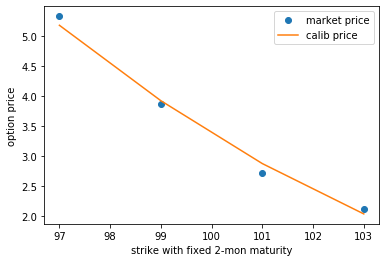

In [18]:
x_co = [filter1[i].strike for i in range(len(filter1))]
y_co = [filter1[i].market_price for i in range(len(filter1))]
plt.plot(x_co, y_co, 'o', label='market price')

y_co = filter1_calibrated_price
plt.plot(x_co, y_co, label = 'calib price')

plt.ylabel('option price')
plt.xlabel('strike with fixed 2-mon maturity')
plt.legend();


- filtering out options of 5-mon maturity

In [19]:
# Take options of 2-mon maturity
filter2 = list(filter(lambda x: x.maturity == 5/12, option_list1))
calibrated_volatility2 = bsm_calibration(gbm1, filter2)
print('>>>>>>>> calibrated_volatility is ' + str(calibrated_volatility2))

>>>>>>>> calibrated_volatility is 0.18617187500000032


In [22]:
gbm1.vol_ratio = calibrated_volatility2

#find calibrated option price
filter2_calibrated_price = [gbm1.bsm_price(filter2[i]) for i in range(len(filter2))]
print('>>>> option prices recovered from calibrated vol:', filter2_calibrated_price)

>>>> option prices recovered from calibrated vol: [7.52657356701409, 6.3355902235228, 5.273494726839061, 4.339981549139665]


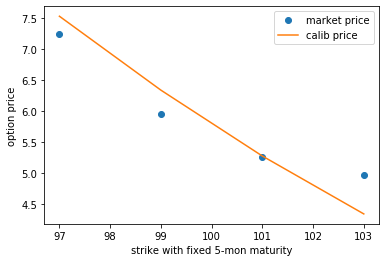

In [23]:
x_co = [filter2[i].strike for i in range(len(filter2))]
y_co = [filter2[i].market_price for i in range(len(filter2))]
plt.plot(x_co, y_co, 'o', label='market price')

y_co = filter2_calibrated_price
plt.plot(x_co, y_co, label = 'calib price')

plt.ylabel('option price')
plt.xlabel('strike with fixed 5-mon maturity')
plt.legend();
